# Fundamentos de Análise de Dados 2022.1

# Trabalho 01 - Regressão: _Naval Propulsion Plants_

**Nome:** Carolina Araújo Dias

# Dataset

_Naval Propulsion Plants_: regressão múltipla (2 variáveis de saída), estimar cada variável de saída separadamente:
- 11934 amostras;
- 16 características reais;
- 2 características reais para estimar, mas estimar somente _GT Compressor decay state coecient_ (remover _GT Turbine decay state coecient_).

# 01. Fazer o _download_ do respectivo banco de dados

**Link:** http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants

Após feito o download, os dados foram salvos em _"../data/naval_data.txt"_.

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.linalg import lu

# Funções Auxiliares

In [2]:
def check_constant_columns(dataframe: pd.DataFrame) -> None:
    """Checa se existem colunas constantes no dataframe
       e imprime o nome e os valores de tais colunas."""
    for column in dataframe.columns:
        if len(dataframe[column].unique()) == 1:
            print(f'Coluna: "{column}", Valor constante: {dataframe[column].unique()}')
            
            
def add_ones_column(data_array: np.array) -> np.array:
    """Adiciona uma coluna de 1's ao final de um array."""
    length = data_array.shape[0]
    return np.c_[data_array, np.ones(length)]

# 02. Fazer a leitura dos dados

In [3]:
column_names = [
    "Lever position",
    "Ship speed",
    "Gas Turbine shaft torque",
    "GT rate of revolutions",
    "Gas Generator rate of revolutions",
    "Starboard Propeller Torque",
    "Port Propeller Torque",
    "Hight Pressure Turbine exit temperature",
    "GT Compressor inlet air temperature",
    "GT Compressor outlet air temperature",
    "HP Turbine exit pressure",
    "GT Compressor inlet air pressure",
    "GT Compressor outlet air pressure",
    "GT exhaust gas pressure",
    "Turbine Injecton Control",
    "Fuel flow",
    "GT Compressor decay state coefficient",
    "GT Turbine decay state coefficient"
]

# to readthe  data using read_csv
# raw_data = pd.read_csv("data/naval_data.txt", sep="   ", header=None, engine='python')

# to read the data using read_fwf
raw_data = pd.read_fwf("../data/naval_data.txt", header=None)
raw_data.columns = column_names

In [4]:
# conferir os dados
raw_data.head()

,Lever position,Ship speed,Gas Turbine shaft torque,GT rate of revolutions,Gas Generator rate of revolutions,Starboard Propeller Torque,Port Propeller Torque,Hight Pressure Turbine exit temperature,GT Compressor inlet air temperature,GT Compressor outlet air temperature,HP Turbine exit pressure,GT Compressor inlet air pressure,GT Compressor outlet air pressure,GT exhaust gas pressure,Turbine Injecton Control,Fuel flow,GT Compressor decay state coefficient,GT Turbine decay state coefficient
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


Só por olharmos para os dados conseguimos enxergar alguns problemas com as colunas. Por exemplo, aparentemente as colunas `Starboard Propeller Torque` e `Port Propeller Torque` são iguais. Além disso, as colunas `GT Compressor inlet air temperature` e `GT Compressor inlet air pressure` parecem ter apenas um valor constante. Vamos checar se isso é verdade.

In [5]:
if raw_data['Starboard Propeller Torque'].equals(raw_data['Port Propeller Torque']):
    print(f'As colunas "Starboard Propeller Torque" e "Port Propeller Torque" são iguais.')
else:
    print(f'As colunas não são iguais.')

As colunas "Starboard Propeller Torque" e "Port Propeller Torque" são iguais.


In [6]:
check_constant_columns(raw_data)

Coluna: "GT Compressor inlet air temperature", Valor constante: [288.]
Coluna: "GT Compressor inlet air pressure", Valor constante: [0.998]


Como identificamos essas colunas problemáticas, iremos removê-las a seguir.

In [7]:
data = raw_data.copy()
data.drop(['GT Compressor inlet air temperature',
           'GT Compressor inlet air pressure',
           'Port Propeller Torque'],
          axis=1,
          inplace=True)

# 03. Se necessário, dividir os dados em conjunto de treinamento (70%) e teste (30%), utilizando a função apropriada do scikit-learn. Quatro NumPy arrays devem ser criados: X_train, y_train, X_test e y_test.

In [8]:
data.drop(["GT Turbine decay state coefficient"],
          axis=1,
          inplace=True)

print(f'Formato dos dados completos: {data.shape}')

X = data.drop(["GT Compressor decay state coefficient"],
              axis=1)

y = data[["GT Compressor decay state coefficient"]]

print(f'Formato de X: {X.shape}')
print(f'Formato de y: {y.shape}')

Formato dos dados completos: (11934, 14)
Formato de X: (11934, 13)
Formato de y: (11934, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=12)

In [10]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# 04. Acrescentar uma coluna de 1s ([1 1 . . . 1]^T) como última coluna da matriz de treinamento Xtrain (vamos chamá-la de X_train_2). Repita o procedimento para a matriz de teste, chamando-a de X_test_2.

[StackOverflow: How to add an extra column to a NumPy array](https://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-a-numpy-array)

In [11]:
add_ones_column(X_train).shape

(8353, 14)

# 05. Calcular o posto das matrizes X_train_2 e X_test_2. Se necessário, ajustar as matrizes X_train_2 e X_test_2.

Antes de remover as 3 colunas problemáticas:

In [12]:
X_raw = raw_data.drop(["GT Compressor decay state coefficient",
                               "GT Turbine decay state coefficient"],
                               axis=1)

add_ones_column(X_raw).shape

(11934, 17)

In [13]:
np.linalg.matrix_rank(add_ones_column(X_raw))

14

Após remover as 3 colunas problemáticas:

In [14]:
np.linalg.matrix_rank(add_ones_column(X_train))

14

In [15]:
np.linalg.matrix_rank(add_ones_column(X_test))

14

In [16]:
add_ones_column(X_train).shape

(8353, 14)

# 06. Calcular a decomposição QR da matriz de treinamento: X_train_2 = QR, usando a função do NumPy apropriada.

In [17]:
Q, R = np.linalg.qr(add_ones_column(X_train))

# 07. Calcular o vetor de coeficientes $\mathbf{\tilde{x}}$ da Equação (1), utilizando a função do NumPy `linalg.solve`.

In [18]:
coefs_lineares = np.linalg.solve(R, np.dot(Q.T, y_train))

# 08. Calcular as estimativas do modelo para os valores de treinamento e test, utilizando o vetor de coeficientes $\mathbf{\tilde{x}}$, calculado no item anterior.

In [19]:
y_train_preds = []

for i in range(len(X_train)):
    y_train_preds.append(np.dot(np.squeeze(coefs_lineares), add_ones_column(X_train)[i]))

In [20]:
y_test_preds = []

for i in range(len(X_test)):
    y_test_preds.append(np.dot(np.squeeze(coefs_lineares), add_ones_column(X_test)[i]))

# 09. Gerar um gráfico com os valores reais de treinamento (ytrain) no eixo das abscissas e valores estimados de treinamento  no eixo das ordenadas. Acrescentar ao gráfico uma reta pontilhada a +45◦ do eixo das abscissas. Certifique-se que ambos os eixos estão na mesma proporção, ou seja, a reta pontilhada deve estar de fato a +45◦ do eixo das abscissas.

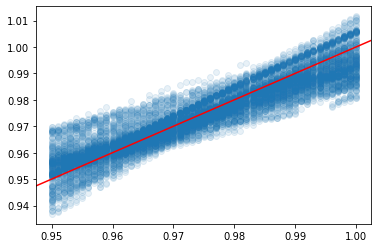

In [21]:
plt.scatter(x=y_train, y=y_train_preds, alpha=0.1)
plt.axline((1, 1), slope=1, color='r')
plt.show()

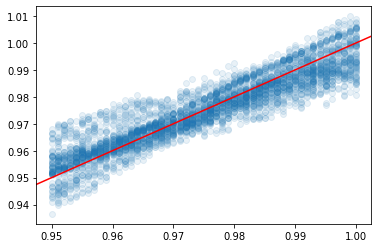

In [22]:
plt.scatter(x=y_test, y=y_test_preds, alpha=0.1)
plt.axline((1, 1), slope=1, color='r')
plt.show()

# 10. Calcular a **raiz quadrada do erro médio quadrático** (RMSE) dos dados de treinamento.

In [23]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [25]:
rmse(np.array(y_train_preds), y_train)

0.020011062958884666

In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(np.array(y_train_preds), y_train, squared=False)

0.005861203460006047

In [28]:
mean_squared_error(np.array(y_test_preds), y_test, squared=False)

0.005766994938583484

In [29]:
rmse(np.array(y_test_preds), y_test)

0.020020029783453658

# Para o outro target

In [30]:
data = raw_data.copy()
data.drop(['GT Compressor inlet air temperature',
           'GT Compressor inlet air pressure',
           'Port Propeller Torque'],
          axis=1,
          inplace=True)

data.drop(["GT Compressor decay state coefficient"],
          axis=1,
          inplace=True)


X = data.drop(["GT Turbine decay state coefficient"],
              axis=1)

y = data[["GT Turbine decay state coefficient"]]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=12)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Q, R = np.linalg.qr(add_ones_column(X_train))

coefs_lineares = np.linalg.solve(R, np.dot(Q.T, y_train))


y_train_preds = []

for i in range(len(X_train)):
    y_train_preds.append(np.dot(np.squeeze(coefs_lineares), add_ones_column(X_train)[i]))
    
    
y_test_preds = []

for i in range(len(X_test)):
    y_test_preds.append(np.dot(np.squeeze(coefs_lineares), add_ones_column(X_test)[i]))

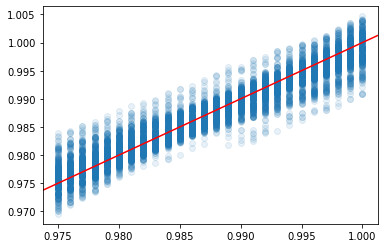

In [31]:
plt.scatter(x=y_train, y=y_train_preds, alpha=0.1)
plt.axline((1, 1), slope=1, color='r')
plt.show()

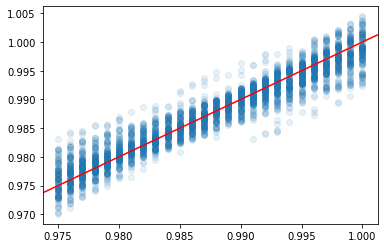

In [36]:
plt.scatter(x=y_test, y=y_test_preds, alpha=0.1)
plt.axline((1, 1), slope=1, color='r')
#plt.axis('scaled')
plt.show()

In [33]:
mean_squared_error(np.array(y_train_preds), y_train, squared=False)

0.002250458361614906

In [34]:
mean_squared_error(np.array(y_test_preds), y_test, squared=False)

0.0022108340999288877